# K-means

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters
from numpy.random import randn, seed

In [2]:
%config InlineBackend.figure_format = "retina"

### Distortion Function

The distortion function for the k-means algorithm
$$
    J(\boldsymbol \mu) = \sum_{n=1}^N\sum_{k_1}^K r_{nk} ||{\bf x}_n - {\boldsymbol \mu_k}||^2
$$

is minimized by following the EM steps:


**E-Step**: Minime $J$ w.r.t. $\{r_{nk}\}_{n,k}$ keeping $\{{\bf\mu}_k\}_{k}$ fixed. Assign the $n$-th datapoint to the closest prototype, i.e.,

$$
    r_{n\hat k} =
    \begin{cases}
        1 & \hat k = \arg\min_k||{\bf x}_n - {\boldsymbol\mu}_k||^2\\
        0 & \text{otherwise}
    \end{cases}
$$


**M-Step**: Minimize $J$ w.r.t $\{{\bf\mu}_k\}_{k}$ keeping $\{r_{nk}\}_{n,k}$ fixed as
$$
    {\bf\mu}_{\hat k} = \frac{1}{N_{\hat k}}\sum_{\{n|{\bf x}_n\in C_{\hat k}\}}{\bf x}_n
$$

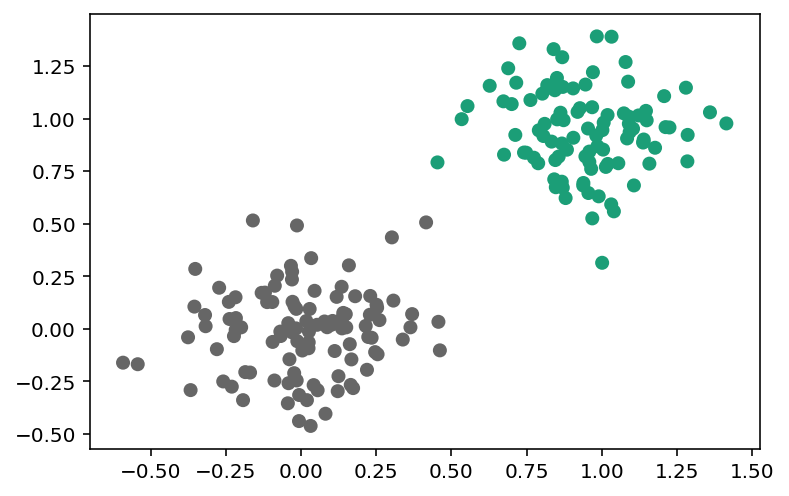

In [3]:
X, y, _ = make_biclusters((200, 2), 2, noise=0.2, random_state=314, minval=0, maxval=1)
plt.scatter(*X.T, c=y.argmax(axis=0), cmap="Dark2")

In [4]:
class KMeans:
    def __init__(self, X, y, K, prototype_init=None, random_state=None):
        seed(random_state)
        self.N, self.M = X.shape
        self.K =K
        self.X = X
        self.y = y
        self.prototypes = self._initialize_protypes(prototype_init, random_state)
        self.i = 0
        self.distortion_hist = [self.compute_distortion()]
    
    def _initialize_protypes(self, prototype, random_state):
        if prototype is None:
            seed(random_state)
            return np.random.randn(self.K, self.M)
        else:
            return prototype
    
    def compute_distances(self):
        """
        Compute the euclidian distance between the dataset and
        each of the prototypes
        """
        distance = (self.X[np.newaxis, ...] - self.prototypes[:, np.newaxis]) ** 2
        return distance
        
    def e_step(self):
        R = self.compute_distances()
        R = R.sum(axis=-1)
        R = R.argmin(axis=0)
        
        r = np.ones((self.N, self.K)).cumsum(axis=1) - 1 == R[:, np.newaxis]
        return r
        
    def m_step(self):
        r = self.e_step()
        prototypes = (self.X[:, np.newaxis] * r[..., np.newaxis]).mean(axis=0)
        return prototypes
    
    def update_prototypes(self):
        self.prototypes = self.m_step()
        Ji = self.compute_distortion()
        self.distortion_hist.append(Ji)
    
    def compute_distortion(self):
        J = self.compute_distances()
        r = self.e_step()
        return (J.sum(axis=-1).T * r).sum()
    
    def fit(self, threshold=1e-6, save_proto_hist=False):
        diff = np.inf
        if save_proto_hist:
            proto_hist =[self.prototypes]
            
        while diff > threshold:
            self.update_prototypes()            
            *_, J0, J1 = self.distortion_hist
            diff = np.abs(J1 / J0 - 1)
            if save_proto_hist:
                proto_hist.append(self.prototypes)
        
        if save_proto_hist:
            return proto_hist
        

In [5]:
mu_0 = np.array([
    [-1, -1],
    [1.5, 1.5]
])

km = KMeans(X, y, 2, prototype_init=mu_0)

hist = km.fit(save_proto_hist=True)

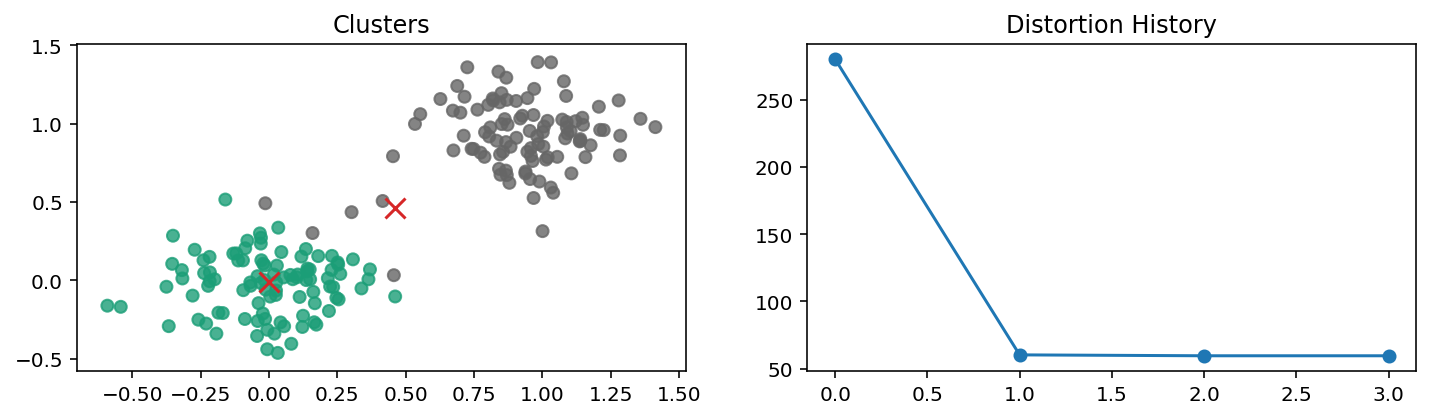

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

R = km.e_step().argmax(axis=1)
ax[1].plot(km.distortion_hist, marker="o")
ax[0].scatter(*X.T, c=R, cmap="Dark2", alpha=0.8)
ax[0].scatter(*km.prototypes.T, c="tab:red", s=100, marker="x");

ax[0].set_title("Clusters");
ax[1].set_title("Distortion History");

In [7]:
R

array([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 1])